<a href="https://colab.research.google.com/github/amalphonse/SPAIC_sg_fruit_360/blob/master/Ivy_Fruits360_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of Fruits And Vegetables

In [0]:
# !pip install kaggle

# !mkdir .kaggle

# import json
# token = {"username":"ivyclare","key":"17ee8bd3b41486d62e7eb9257bd812d4"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

# !chmod 600 /content/.kaggle/kaggle.json

# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
 
 
# !kaggle config set -n path -v{/content}

# #!kaggle datasets download -d shayanfazeli/heartbeat -p /content
# !kaggle datasets download -d moltean/fruits -p /content
# !unzip \*.zip

### Import libraries

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os
import glob

from PIL import Image


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load And Visualize Data 

Given the data is to 
The image data for this competition are too large to fit in memory in kernels. This kernel demonstrates how to access individual images in the zip archives without having to extract them or load the archive into memory.

In [6]:
#Now we load images and labels from folder into pytorch tensor
data_dir = 'fruits-360'
train_dir = 'fruits-360/Training'
test_dir = 'fruits-360/Test'
batch_size = 32

# Tansform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),                                  
        #transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}


dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])
# splitting our data
valid_size  = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

test_dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False),
              'test': DataLoader(test_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Samples in Test: ",len(test_dataset))
print("Number of Classes: ",len(dataset.classes))


Total Number of Samples:  57276
Number of Samples in Train:  45821
Number of Samples in Valid:  11455
Number of Samples in Test:  19548
Number of Classes:  114


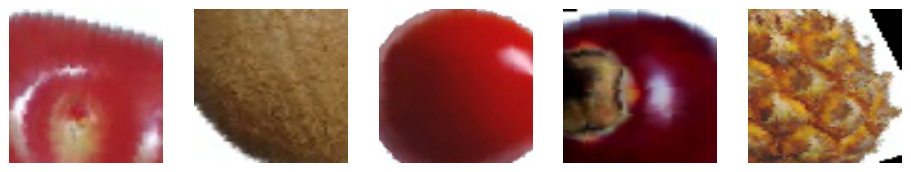

In [7]:
## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    #ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)

### Building MLP Network

### Transfer Learning

### Load Pretrained Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'inception' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True) 
    #model = models.resnet34(pretrained=True)
    num_in_features = 2048 #512 
    print(model.fc)
elif model_name == 'inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits=False
    num_in_features = 2048
    print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 103328537.86it/s]


Linear(in_features=2048, out_features=1000, bias=True)


### Freeze Parameters and Build Classifier

In [0]:
#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
    param.require_grad = False

# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
      
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))
        
    else:
      
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        
#         classifier.add_module('relu1', nn.ReLU())
#         classifier.add_module('drop1', nn.Dropout(.5))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [10]:
hidden_layers = None #[1050 , 500] #[4096, 1024] #None#[4096, 1024, 256][512, 256, 128] [1050 , 500]

classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)

 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
   # Decay LR by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.0001,weight_decay=0.001, momentum=0.9)
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
  #sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

#     #criterion = nn.NLLLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr= 0.00001)
#     sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#criterion = nn.CrossEntropyLoss()

elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


### Training The Model

In [0]:
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':   
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # calculate average time over an epoch
            #elapshed_epoch = time.time() - start/            
            #print('Epoch {}/{} - completed in: {:.0f}m {:.0f}s'.format(epoch+1, num_epochs,elapshed_epoch // 60, elapshed_epoch % 60))
            
            if(phase == 'train'):
                train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              #sched.step(epoch_acc)
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                #model_save_name = "ResNetDeepFlowers.pt"
                model_save_name = "FruitInception.pt"
                path = F"/content/drive/My Drive/{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results
  #Resnet34 = 68.8%, 50 epochs, vggDeepFlowers

In [0]:
epochs = 20
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/20
----------
train Loss: 1.7560 Acc: 0.6375
valid Loss: 0.2047 Acc: 0.9479

Epoch 2/20
----------
train Loss: 0.2959 Acc: 0.9265
valid Loss: 0.0793 Acc: 0.9775

Epoch 3/20
----------


### Check for Overfitting

In [0]:
# Plot of Losses
train_results = np.array(train_results)
valid_results = np.array(valid_results)

#print(train_results)
#print(valid_results[:,0])
plt.plot(train_results[:,0])
plt.plot(valid_results[:,0])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

#Plot of Accuracies
plt.plot(train_results[:,1])
plt.plot(valid_results[:,1])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

### Load Saved Model 

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Kaggle/Inception.pt'))
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

### Testing The Model

#### Test Model Per Class

In [0]:
def test_per_class(model, test_loader, criterion, classes):
    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        # Move input and label tensors to the default device
        data,target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        
        # calculate test accuracy for each object class
        for i in range(len(target) - 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [19]:
# dataloaders['train']
# len(dataset.classes)
# model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

test_per_class(model, dataloaders['test'], criterion, dataset.classes)

Test Loss: 0.020984

Test Accuracy of     0: 100% (159/159)
Test Accuracy of     1: 100% (144/144)
Test Accuracy of     2: 100% (159/159)
Test Accuracy of     3: 100% (158/158)
Test Accuracy of     4: 87% (136/156)
Test Accuracy of     5: 100% (159/159)
Test Accuracy of     6: 100% (148/148)
Test Accuracy of     7: 100% (158/158)
Test Accuracy of     8: 96% (153/159)
Test Accuracy of     9: 100% (140/140)
Test Accuracy of    10: 100% (161/161)
Test Accuracy of    11: 92% (147/159)
Test Accuracy of    12: 100% (212/212)
Test Accuracy of    13: 100% (159/159)
Test Accuracy of    14: 100% (138/138)
Test Accuracy of    15: 100% (161/161)
Test Accuracy of    16: 97% (157/161)
Test Accuracy of    17: 100% (147/147)
Test Accuracy of    18: 97% (157/161)
Test Accuracy of    19: 100% (149/149)
Test Accuracy of    20: 100% (161/161)
Test Accuracy of    21: 100% (159/159)
Test Accuracy of    22: 100% (159/159)
Test Accuracy of    23: 100% (160/160)
Test Accuracy of    24: 100% (159/159)
Test Accu

### Test With Single Image

Value: 4
Apple Golden 3


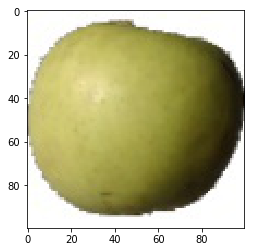

In [21]:
def test_with_single_image(model, file, transform, classes):
    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()
        
        
test_with_single_image(model, 'fruits-360/Test/Apple Golden 3/311_100.jpg', data_transforms['test'], dataset.classes)